In [1]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.serif'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
%matplotlib inline

## validation

In [25]:
n_genes = 150
gse152586 = pd.read_csv('../../source_with_direction/PPI/DEGs/SARS-CoV2_GSE152586_iDEP.csv')
gse152586 = gse152586[(gse152586['adj-P-Val']<=0.05)&(gse152586['Symbol'].notnull())].sort_values('logFC')
gse152586_activate = gse152586['Symbol'].values[-n_genes:]
gse152586_inhibit = gse152586['Symbol'].values[:n_genes]

with open(f'./gse152586_activate_top{n_genes}.txt', 'w') as f:
    f.write('\n'.join(gse152586_activate)+'\n')

with open(f'./gse152586_inhibit_top{n_genes}.txt', 'w') as f:
    f.write('\n'.join(gse152586_inhibit)+'\n')

In [40]:
gse154783 = pd.read_csv('../../source_with_direction/PPI/DEGs/SARS-CoV2_GSE154783_DESeq2.txt.gz',sep='\t')
gse154783 = gse154783[(gse154783['hmgb1.padj']<=0.05)&(gse154783['gene_id'].notnull())].sort_values('hmgb1.l2fc')
gse154783_activate = gse154783['gene_id'].values[:n_genes]
gse154783_inhibit = gse154783['gene_id'].values[-n_genes:]

with open(f'./gse154783_activate_top{n_genes}.txt', 'w') as f:
    f.write('\n'.join(gse154783_activate)+'\n')

with open(f'./gse154783_inhibit_top{n_genes}.txt', 'w') as f:
    f.write('\n'.join(gse154783_inhibit)+'\n')

In [2]:
clinicaltrial = pd.read_csv('../../map_drugs/clinicaltrial.csv')
clinicaltrial_all = clinicaltrial['ChEMBL'].unique()

In [3]:
cmapID_map = pd.read_csv('./cmap_IDmap.txt',sep='\t', header=None)
cmapID_map = cmapID_map.drop_duplicates(0)
cmapID_map = pd.Series(index=cmapID_map[0].values, data=cmapID_map[1].values)

In [4]:
gse152586_res = pd.read_csv('./GSE152586-50_cmap.txt',sep='\t')
gse152586_res['ChEMBL'] = gse152586_res['Name'].map(cmapID_map)
gse152586_res = gse152586_res[gse152586_res['ChEMBL'].notnull()].drop_duplicates('ChEMBL')
gse152586_res['Clinical Trial'] = 1
gse152586_res['Clinical Trial'] = gse152586_res['Clinical Trial'].where(gse152586_res['ChEMBL'].isin(clinicaltrial_all), 0)
gse152586_res['prediction'] = gse152586_res['Score'] - gse152586_res['Score'].min()
gse152586_res['prediction'] = gse152586_res['prediction']/gse152586_res['prediction'].max()

In [5]:
gse154783_res = pd.read_csv('./GSE154783-50_cmap.txt',sep='\t')
gse154783_res['ChEMBL'] = gse154783_res['Name'].map(cmapID_map)
gse154783_res = gse154783_res[gse154783_res['ChEMBL'].notnull()].drop_duplicates('ChEMBL')
gse154783_res['Clinical Trial'] = 1
gse154783_res['Clinical Trial'] = gse154783_res['Clinical Trial'].where(gse154783_res['ChEMBL'].isin(clinicaltrial_all), 0)
gse154783_res['prediction'] = gse154783_res['Score'] - gse154783_res['Score'].min()
gse154783_res['prediction'] = gse154783_res['prediction']/gse154783_res['prediction'].max()

## ROC curve

In [6]:
jianhua_res = pd.read_csv('../../map_drugs/drugs_rank.csv')
jianhua_res['prediction'] = jianhua_res['Rating Score']-jianhua_res['Rating Score'].min()
jianhua_res['prediction'] = jianhua_res['prediction']/jianhua_res['prediction'].max()

/var/folders/j3/xh8_29192m7_78jq877dkg800000gn/T/ipykernel_31332/3418051063.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 1], [0, 1], 'k--', color='grey')


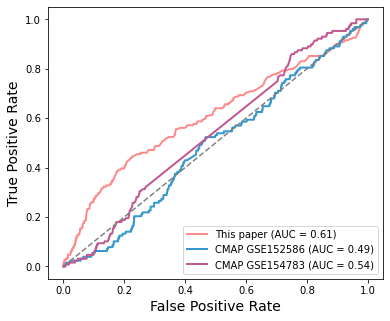

In [8]:
f, ax = plt.subplots(figsize=(6,5))

def draw_roc(df, name, color):
    y_label = df['Clinical Trial'].values
    y_pre = df['prediction'].values
    fpr, tpr, thersholds = roc_curve(y_label, y_pre, pos_label=1)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, '-', label=f'{name} (AUC = {roc_auc:.2f})', lw=2, color=color)

draw_roc(jianhua_res, 'This paper','#FF8A8C')
draw_roc(gse152586_res, 'CMAP GSE152586','#3497CF')
draw_roc(gse154783_res, 'CMAP GSE154783','#C1588F')
ax.plot([0, 1], [0, 1], 'k--', color='grey')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
# ax.set_title('ROC Curve')
ax.legend(loc="lower right")
f.savefig('./Fig3c.pdf')